In [53]:
%load_ext autoreload
%autoreload 2

import os

# https://stackoverflow.com/questions/30791550/limit-number-of-threads-in-numpy
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6

import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats
import sklearn.cluster
import sklearn.mixture

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from handygenome import common
from handygenome.common import ChromDict, Interval
from handygenome.variant.vcfspec import Vcfspec

from handygenome.sv.breakends import Breakends
from handygenome.variant.variantplus import VariantPlus, VariantPlusList
from handygenome.igvhandle import IGVHandle

import handygenome.variant.filter as libfilter
import handygenome.variant.variantplus as libvp

import handygenome.cnv.baf as libbaf

In [4]:
FASTA_PATH_HG19 = common.DEFAULT_FASTA_PATHS['hg19']
FASTA_PATH_HG38 = common.DEFAULT_FASTA_PATHS['hg38']

FASTA_HG19 = common.DEFAULT_FASTAS['hg19']
FASTA_HG38 = common.DEFAULT_FASTAS['hg38']
CHROMDICT_HG19 = common.DEFAULT_CHROMDICTS['hg19']
CHROMDICT_HG38 = common.DEFAULT_CHROMDICTS['hg38']

In [5]:
sampleid = 'LU-14'

In [6]:
import handygenome.cnv.gcfraction as libgcfraction
import handygenome.cnv.mosdepth as libmosdepth
import handygenome.cnv.misc as cnvmisc
import handygenome.pyranges_helper as pyranges_helper
import handygenome.variant.variantplus as libvp
import handygenome.cnv.rcopynumber as rcopynumber
import handygenome.plot.genomeplot as libgenomeplot

In [7]:
wgs_normal_mosdepth_output_path = f'/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/results/{sampleid}.normal/{sampleid}.normal.regions.bed.gz'
wgs_tumor_mosdepth_output_path = f'/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/results/{sampleid}.tumor/{sampleid}.tumor.regions.bed.gz'
baf_vcf_path = f'/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/annotation_230126/{sampleid}.readstats.het_filtered.tumorannot.vcf.gz'

# Filtered germline variant distribution check

In [10]:
germline_vafdf = libvp.get_vafdf(baf_vcf_path, sampleid='LU-14_normal', nproc=10)

[KST 2023-04-06 14:29:48.760 variantplus.get_vafdf] line 1838: Extracting vcf position information
[KST 2023-04-06 14:30:49.526 variantplus.get_vafdf] line 1847: Running parallel jobs
[KST 2023-04-06 14:32:00.710 variantplus.get_vafdf] line 1854: Concatenating split job dataframes


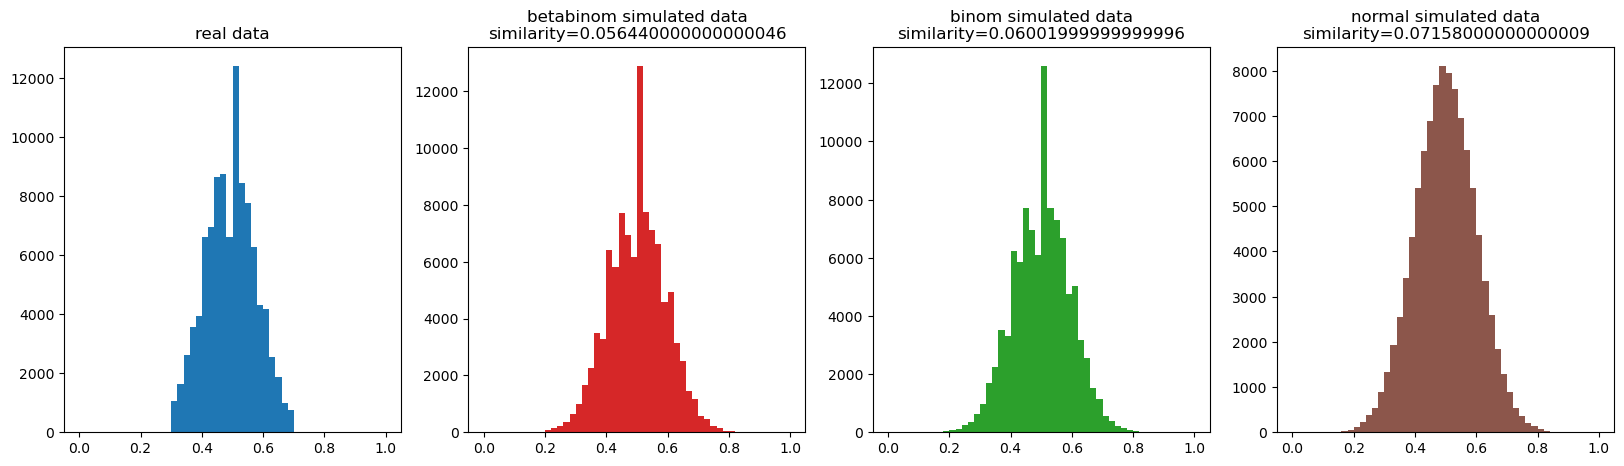

In [11]:
a = b = 10000
mean_depth = 30
real_data = germline_vafdf['vaf_LU-14_normal'].sample(n=100000)

simul_vafs_betabinom = make_simulated_germline_vafs(mean_depth=mean_depth, size=len(real_data), a=a, b=b, mode='betabinom')
simul_vafs_binom = make_simulated_germline_vafs(mean_depth=mean_depth, size=len(real_data), mode='binom')
simul_vafs_normal = make_simulated_germline_vafs_normal(size=len(real_data), std=0.1)

sim_betabinom = scipy.stats.kstest(simul_vafs_betabinom, real_data).statistic
sim_binom = scipy.stats.kstest(simul_vafs_binom, real_data).statistic
sim_normal = scipy.stats.kstest(simul_vafs_normal, real_data).statistic

#

fig, axs = plt.subplots(1, 4, gridspec_kw=dict(wspace=0.2), figsize=(20, 5))

axs[0].set_title(f'real data')
_ = axs[0].hist(real_data, color='tab:blue', range=(0, 1), bins=50)

axs[1].set_title(f'betabinom simulated data\nsimilarity={sim_betabinom}')
_ = axs[1].hist(simul_vafs_betabinom, color='tab:red', range=(0, 1), bins=50)

axs[2].set_title(f'binom simulated data\nsimilarity={sim_binom}')
_ = axs[2].hist(simul_vafs_binom, color='tab:green', range=(0, 1), bins=50)

axs[3].set_title(f'normal simulated data\nsimilarity={sim_normal}')
_ = axs[3].hist(simul_vafs_normal, color='tab:brown', range=(0, 1), bins=50)

# Baf distribution gap check

In [19]:
data = dict()
# for size in (100, 200, 500, 1000, 2000, 5000, 10000, 20000):
for size in (1000, 2000):
    print(f'size {size}')
    data[size] = libbaf.make_simulation_data(mean_depth=34, size=size, reps=1, true_bafs=true_bafs)

size 1000
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
size 2000
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5


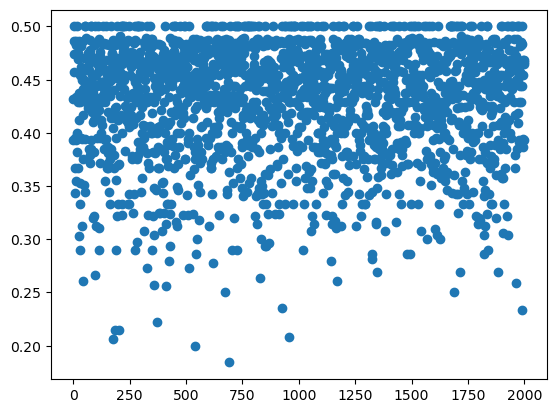

In [22]:
ys = data[2000]['baf'][0.5][0]
xs = np.arange(len(ys))
plt.plot(xs, ys, linestyle='', marker='o', )

In [25]:
vcf_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/LU-14_normal/results/LU-14_normal.haplotypecaller.edit.snv.bcf.gz'
vcf = pysam.VariantFile(vcf_path)

In [52]:
vaflist = list()
for idx, vr in enumerate(vcf.fetch()):
    if idx % 1000000 == 0:
        print(idx)
    vaflist.append(vr.samples['JKL-LU-14-blood-wgs-ILLUMINA']['AF'][0])

vaflist = np.array(vaflist)
baflist = libbaf.get_bafs(vaflist)

0
1000000
2000000
3000000
4000000


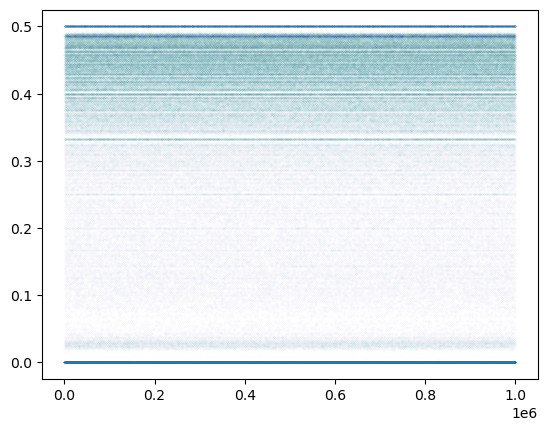

In [51]:
ys = np.random.choice(baflist, 1_000_000)
xs = np.arange(len(ys))
plt.plot(xs, ys, linestyle='', marker='o', alpha=0.05, markersize=0.1)

# Make simulation data

In [8]:
true_bafs = np.round(np.arange(0.01, 0.51, 0.01), 2)

In [101]:
data = dict()
# for size in (100, 200, 500, 1000, 2000, 5000, 10000, 20000):
for size in (100, 1000, 10000,):
    print(f'size {size}')
    data[size] = libbaf.make_simulation_data(mean_depth=34, size=size, reps=100, true_bafs=true_bafs)

size 100
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
size 1000
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
size 10000
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5


### Load real data

In [55]:
realdata_vcf_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/merged_vcfs/LU-F13.merged.vcf.gz.strip.n_readstats.filtered_het.vcf.gz'
vafdf_realdata = libvp.get_vafdf(realdata_vcf_path, sampleid='LU-F13_normal', nproc=20)

[KST 2023-04-10 04:07:08.591 variantplus.get_vafdf] line 1861: Extracting vcf position information
[KST 2023-04-10 04:07:20.373 variantplus.get_vafdf] line 1870: Running parallel jobs
[KST 2023-04-10 04:07:50.613 variantplus.get_vafdf] line 1877: Concatenating split job dataframes


In [58]:
vafs_realdata = vafdf_realdata['vaf_LU-F13_normal'].to_numpy()
bafs_realdata = libbaf.get_bafs(vafs_realdata)

In [157]:
realdata_vcf_paths = {
    '0.5': realdata_vcf_path,
    '0.33_1': '/home/users/twkim/00_data/10_smoking_in_lung/08_haplotypecaller/ES6_2_BAS_3.haplotype.vcf.gz',
    '0.33_2': '/home/users/changhyunnam/Projects/08_LINE1/03_Somatic/10_CEY/03_VCF/germline/haplotypecaller/HC22-08.hc.snp.indel.vcf.gz',
}

In [185]:
vafs_third = list()
with pysam.VariantFile(realdata_vcf_paths['0.33_1']) as vcf:
    for vr in vcf.fetch('7', 0, 30_000_000):
        AD = vr.samples['ES6_2_BAS_3']['AD'][1]
        DP = vr.samples['ES6_2_BAS_3']['DP']
        if DP == 0:
            continue
        vaf = AD / DP
        if vaf < 0.1 or vaf > 0.9:
            continue
        vafs_third.append(vaf)
vafs_third = np.array(vafs_third) 
bafs_third = libbaf.get_bafs(vafs_third)

In [186]:
vafs_third2 = list()
with pysam.VariantFile(realdata_vcf_paths['0.33_2']) as vcf:
    for vr in vcf.fetch('7'):
        AD = vr.samples['HC22-08']['AD'][1]
        DP = vr.samples['HC22-08']['DP']
        if DP == 0:
            continue
        vaf = AD / DP
        if vaf < 0.1 or vaf > 0.9:
            continue
        vafs_third2.append(vaf)
vafs_third2 = np.array(vafs_third2) 
bafs_third2 = libbaf.get_bafs(vafs_third2)

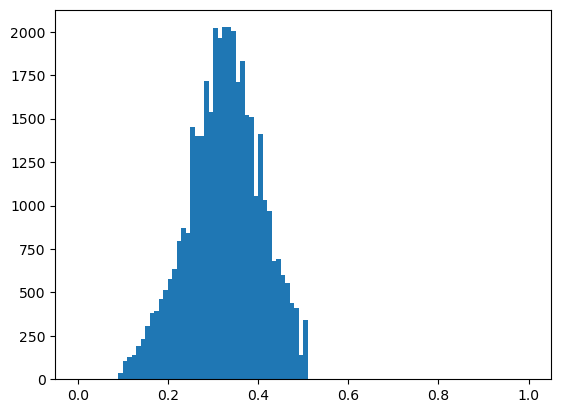

In [187]:
_ = plt.hist(bafs_third, bins=100, range=(0, 1))

In [188]:
bafs_third.mean()

0.32455429221324994

Text(0.5, 1.0, 'type2; sample_size=10000')

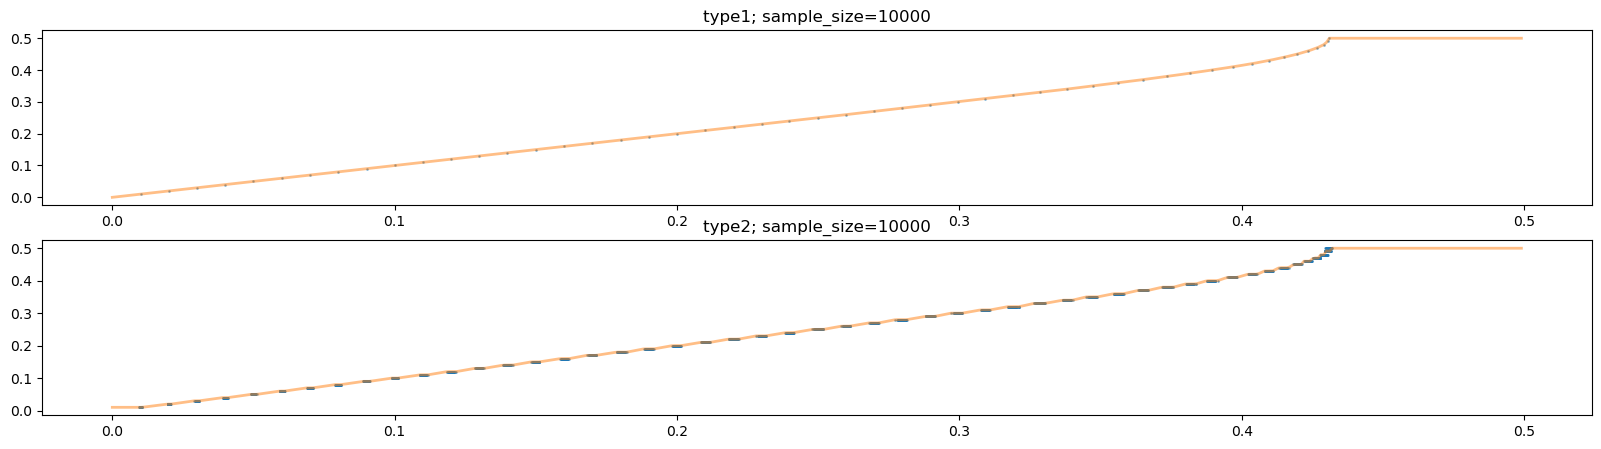

In [164]:
fig, ax = plt.subplots(2, 1, figsize=(20, 5))

size = 10000
subdata = data[size]

def edit_ax(ax, size, bafcorrector, xs, ys):
    ax.plot(xs, ys, linestyle='', marker='o', markersize=1, color='tab:blue', alpha=0.5)
    newxs = np.arange(0, 0.5, 0.001)
    newys = bafcorrector(newxs)
    ax.plot(newxs, newys, color='tab:orange', alpha=0.5, linewidth=2)
    
# type1
bafcorrector, xs, ys = libbaf.make_bafcorrector_type1(subdata)
edit_ax(ax[0], size, bafcorrector, xs, ys)
ax[0].set_title(f'type1; sample_size={size}')

# type2
bafcorrector, xs, ys = libbaf.make_bafcorrector_type2(subdata)
edit_ax(ax[1], size, bafcorrector, xs, ys)
ax[1].set_title(f'type2; sample_size={size}')

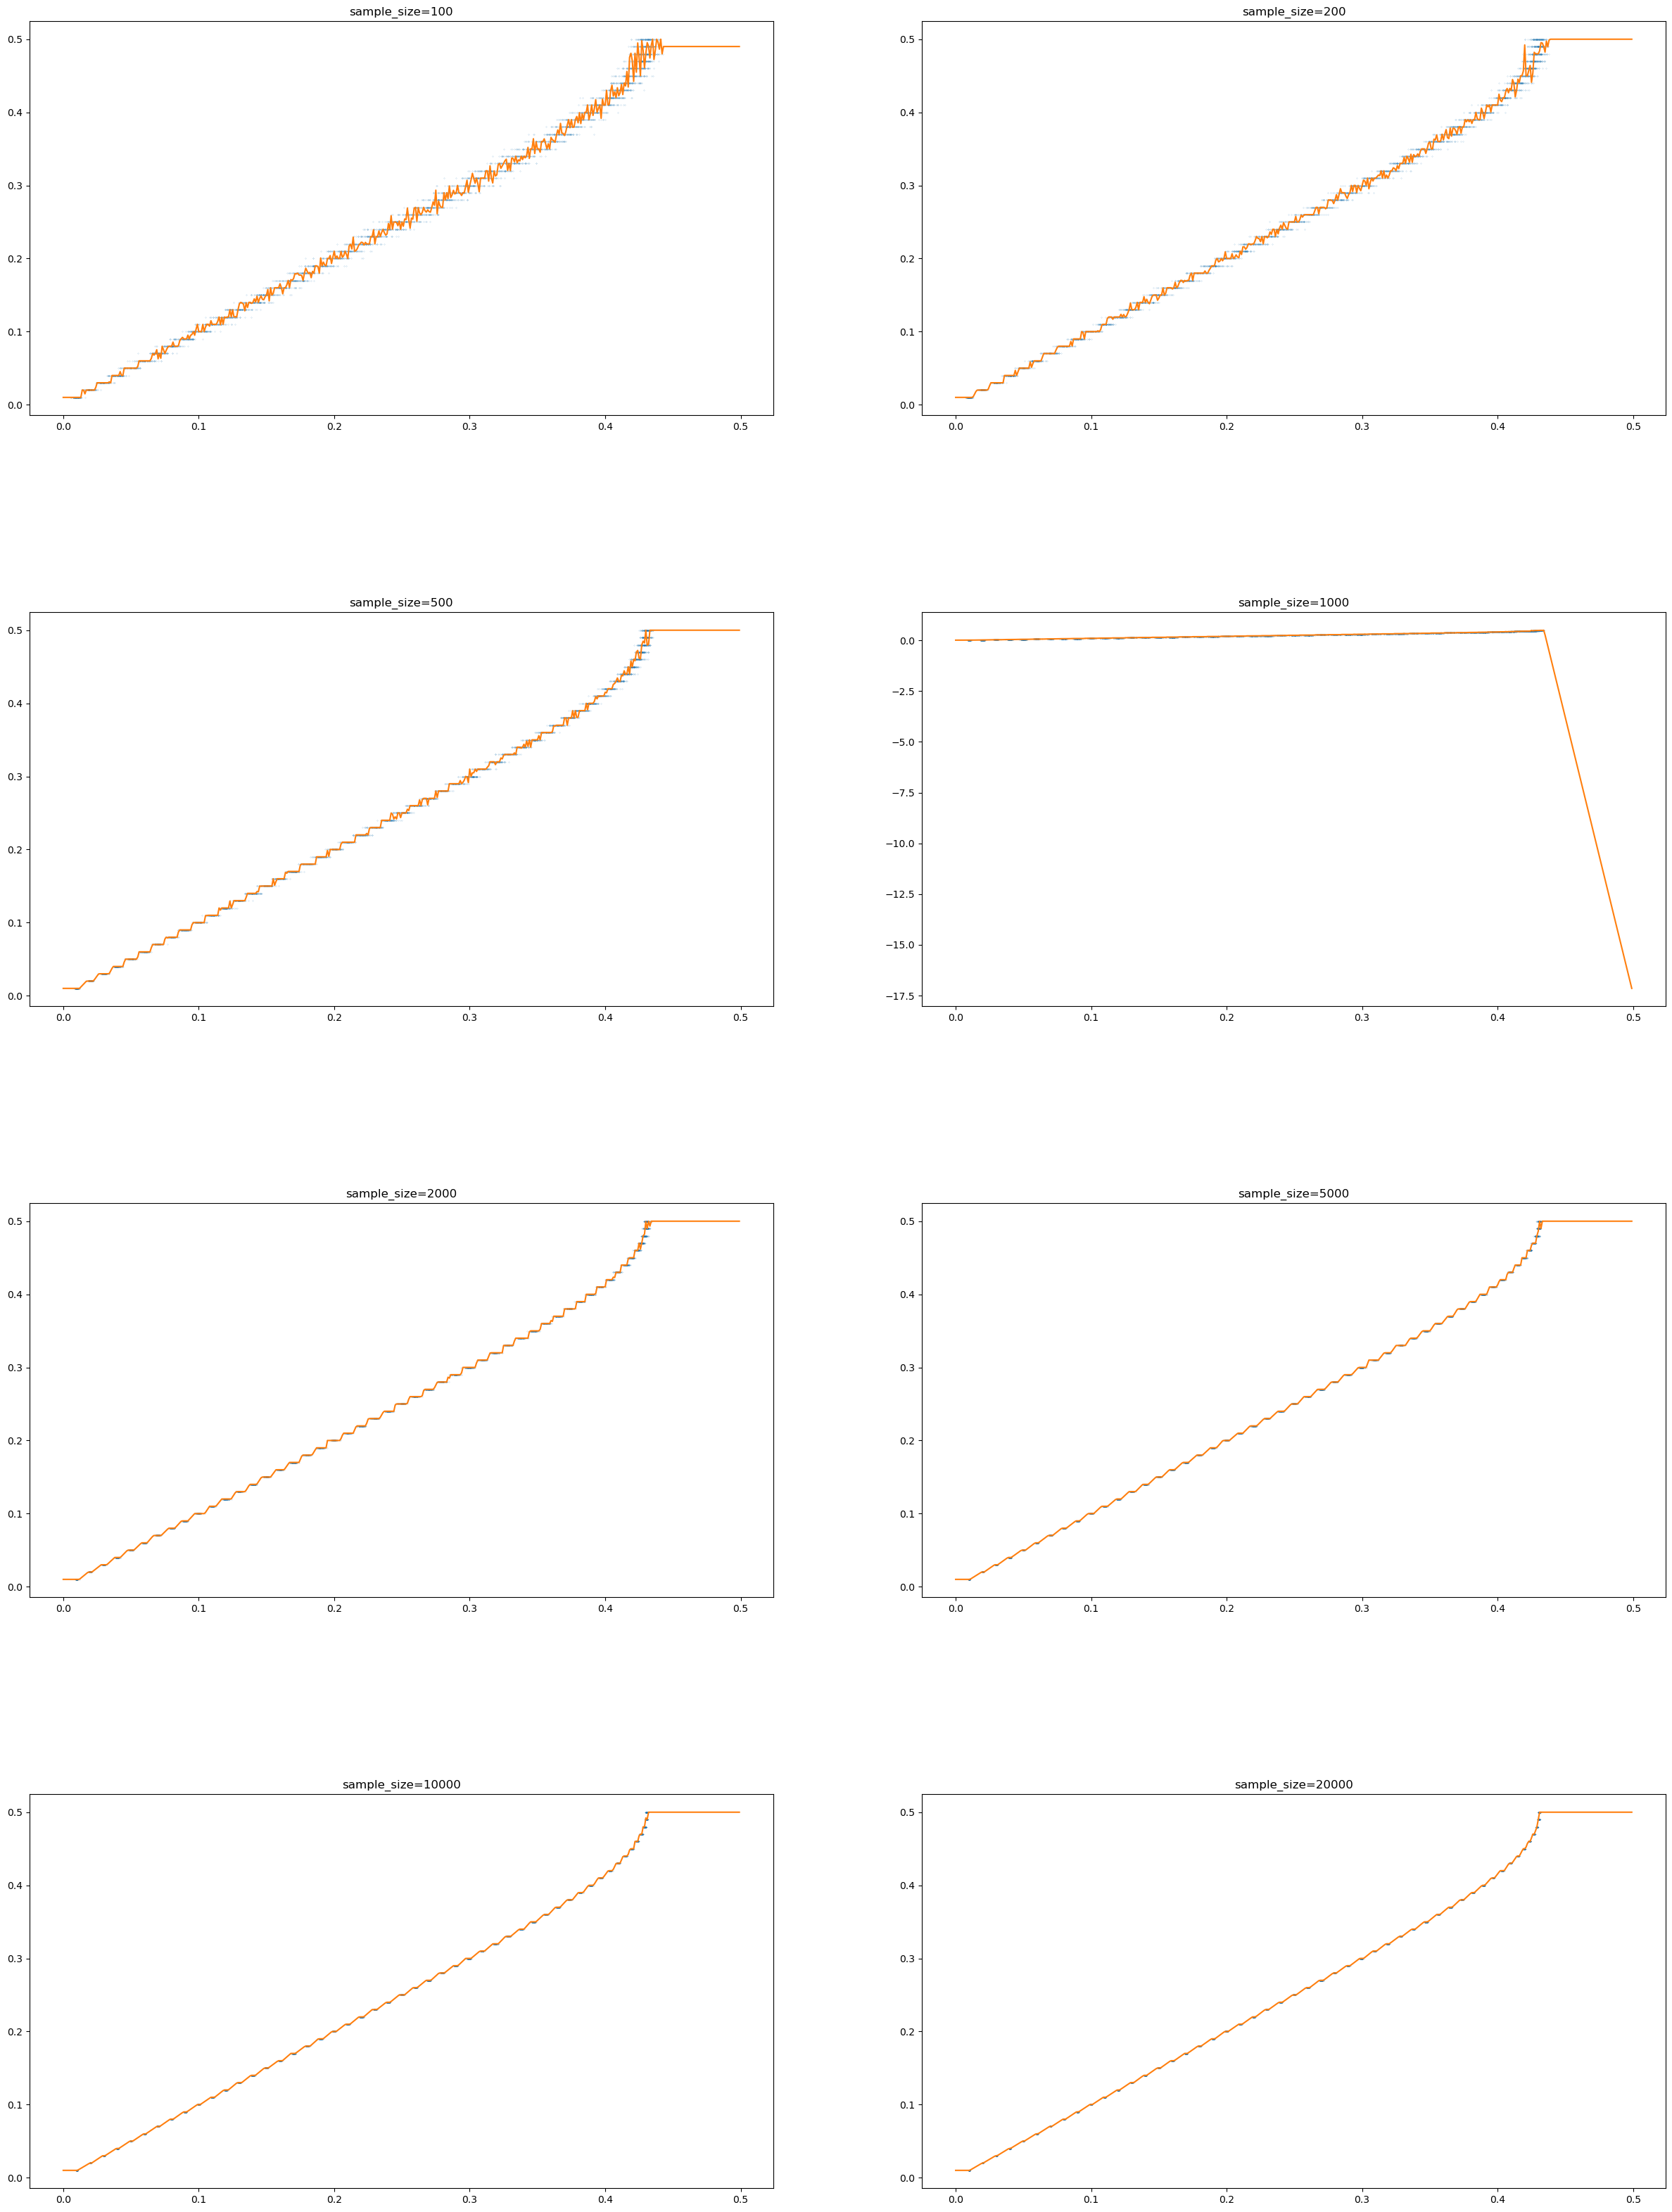

In [131]:
ncol = 2
fig, axs = plt.subplots(
    np.ceil(len(data)/ ncol).astype(int), ncol, 
    figsize=(30, 40), 
    gridspec_kw=dict(hspace=0.5),
)
for ax, (size, subdata) in zip(axs.flat, data.items()):
    ax.set_title(f'sample_size={size}')
    bafcorrector, xs, ys = libbaf.make_bafcorrector_type2(subdata)
    
    ax.plot(xs, ys, linestyle='', marker='o', markersize=.1, color='tab:blue')
    
    newxs = np.arange(0, 0.5, 0.001)
    newys = bafcorrector(newxs)
    ax.plot(newxs, newys, color='tab:orange')

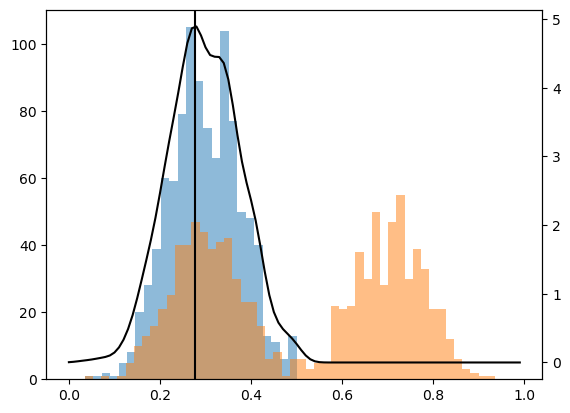

In [190]:
vaf_vals = data[1000]['vaf'][0.3][0]
baf_vals = cnvmisc.get_bafs(vaf_vals)

density = scipy.stats.gaussian_kde(baf_vals)
argmax = scipy.optimize.minimize_scalar(lambda x: -density(x)[0], bounds=(0, 0.5)).x

xs = np.arange(0, 1, 0.01)
ys = density(xs)

fig, ax = plt.subplots()
ax.hist(baf_vals, bins=25, alpha=0.5)
ax.hist(vaf_vals, bins=50, alpha=0.5)
ax2 = ax.twinx()
ax2.plot(xs, ys, color='black')
ax2.axvline(argmax, color='black')

In [ ]:
subidx = 0
subdata = data[1000]

fig, axs = plt.subplots(
    5, 10, figsize=(30, 12), 
    gridspec_kw=dict(wspace=0.8, hspace=2),
    subplot_kw=dict(
        xticks=np.arange(0, 1, 0.2), 
        # ylim=(0, 150_000), 
        # yscale='log',
    ),
)

for idx, ax in enumerate(axs.flat):
    true_baf_val = round(true_bafs[idx], 2)
    baf_values = subdata['baf'][true_baf_val][subidx]
    vaf_values = subdata['vaf'][true_baf_val][subidx]
    
    skew = subdata['skew'][true_baf_val][subidx]
    ebaf_minimize = subdata['minimize'][true_baf_val][subidx]
    ebaf_mixture = subdata['mixture'][true_baf_val][subidx]
    ebaf_mean = subdata['mean'][true_baf_val][subidx]
    
    ax.set_xlim(0, 1)
    ax.set_title('\n'.join([
        f'baf={true_baf_val}',
        f'mean={round(ebaf_mean, 3)}',
        f'argmin={round(ebaf_minimize, 3)}',
        f'mixture={round(ebaf_mixture, 3)}',
        f'skew={round(skew, 3)}',
    ]))
    ax.hist(baf_values, bins=25, alpha=0.5, color='tab:blue')
    ax.hist(vaf_values, bins=50, alpha=0.5, color='tab:red')

In [204]:
bafs_third

array([0.2       , 0.39393939, 0.11538462, ..., 0.25      , 0.37804878,
       0.45714286])

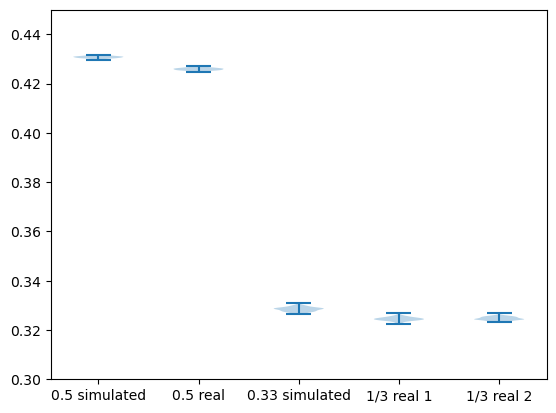

In [210]:
bafmeans_simul_half = data[10000]['baf'][0.5].mean(axis=1)
bafmeans_simul_third = data[10000]['baf'][0.33].mean(axis=1)
bafmeans_real_half = np.random.choice(bafs_realdata, (100, 10000)).mean(axis=1)
bafmeans_real_third1 = np.random.choice(bafs_third, (100, 10000)).mean(axis=1)
bafmeans_real_third2 = np.random.choice(bafs_third2, (100, 10000)).mean(axis=1)

fig, ax = plt.subplots()
_ = ax.violinplot(
    np.array([bafmeans_simul_half, bafmeans_real_half, bafmeans_simul_third, bafmeans_real_third1, bafmeans_real_third2]).T,
    [0, 1, 2, 3, 4],
)
ax.set_ylim(0.3, 0.45)
ax.set_xticks([0, 1, 2, 3, 4])
_ = ax.set_xticklabels(['0.5 simulated', '0.5 real', '0.33 simulated', '1/3 real 1', '1/3 real 2'])

In [213]:
print(
    bafmeans_real_half.mean() 
    / bafmeans_simul_half.mean()
)
print(
    np.concatenate((bafmeans_real_third1, bafmeans_real_third2)).mean() 
    / bafmeans_simul_third.mean()
)

0.9887149842372994
0.9881992557945583


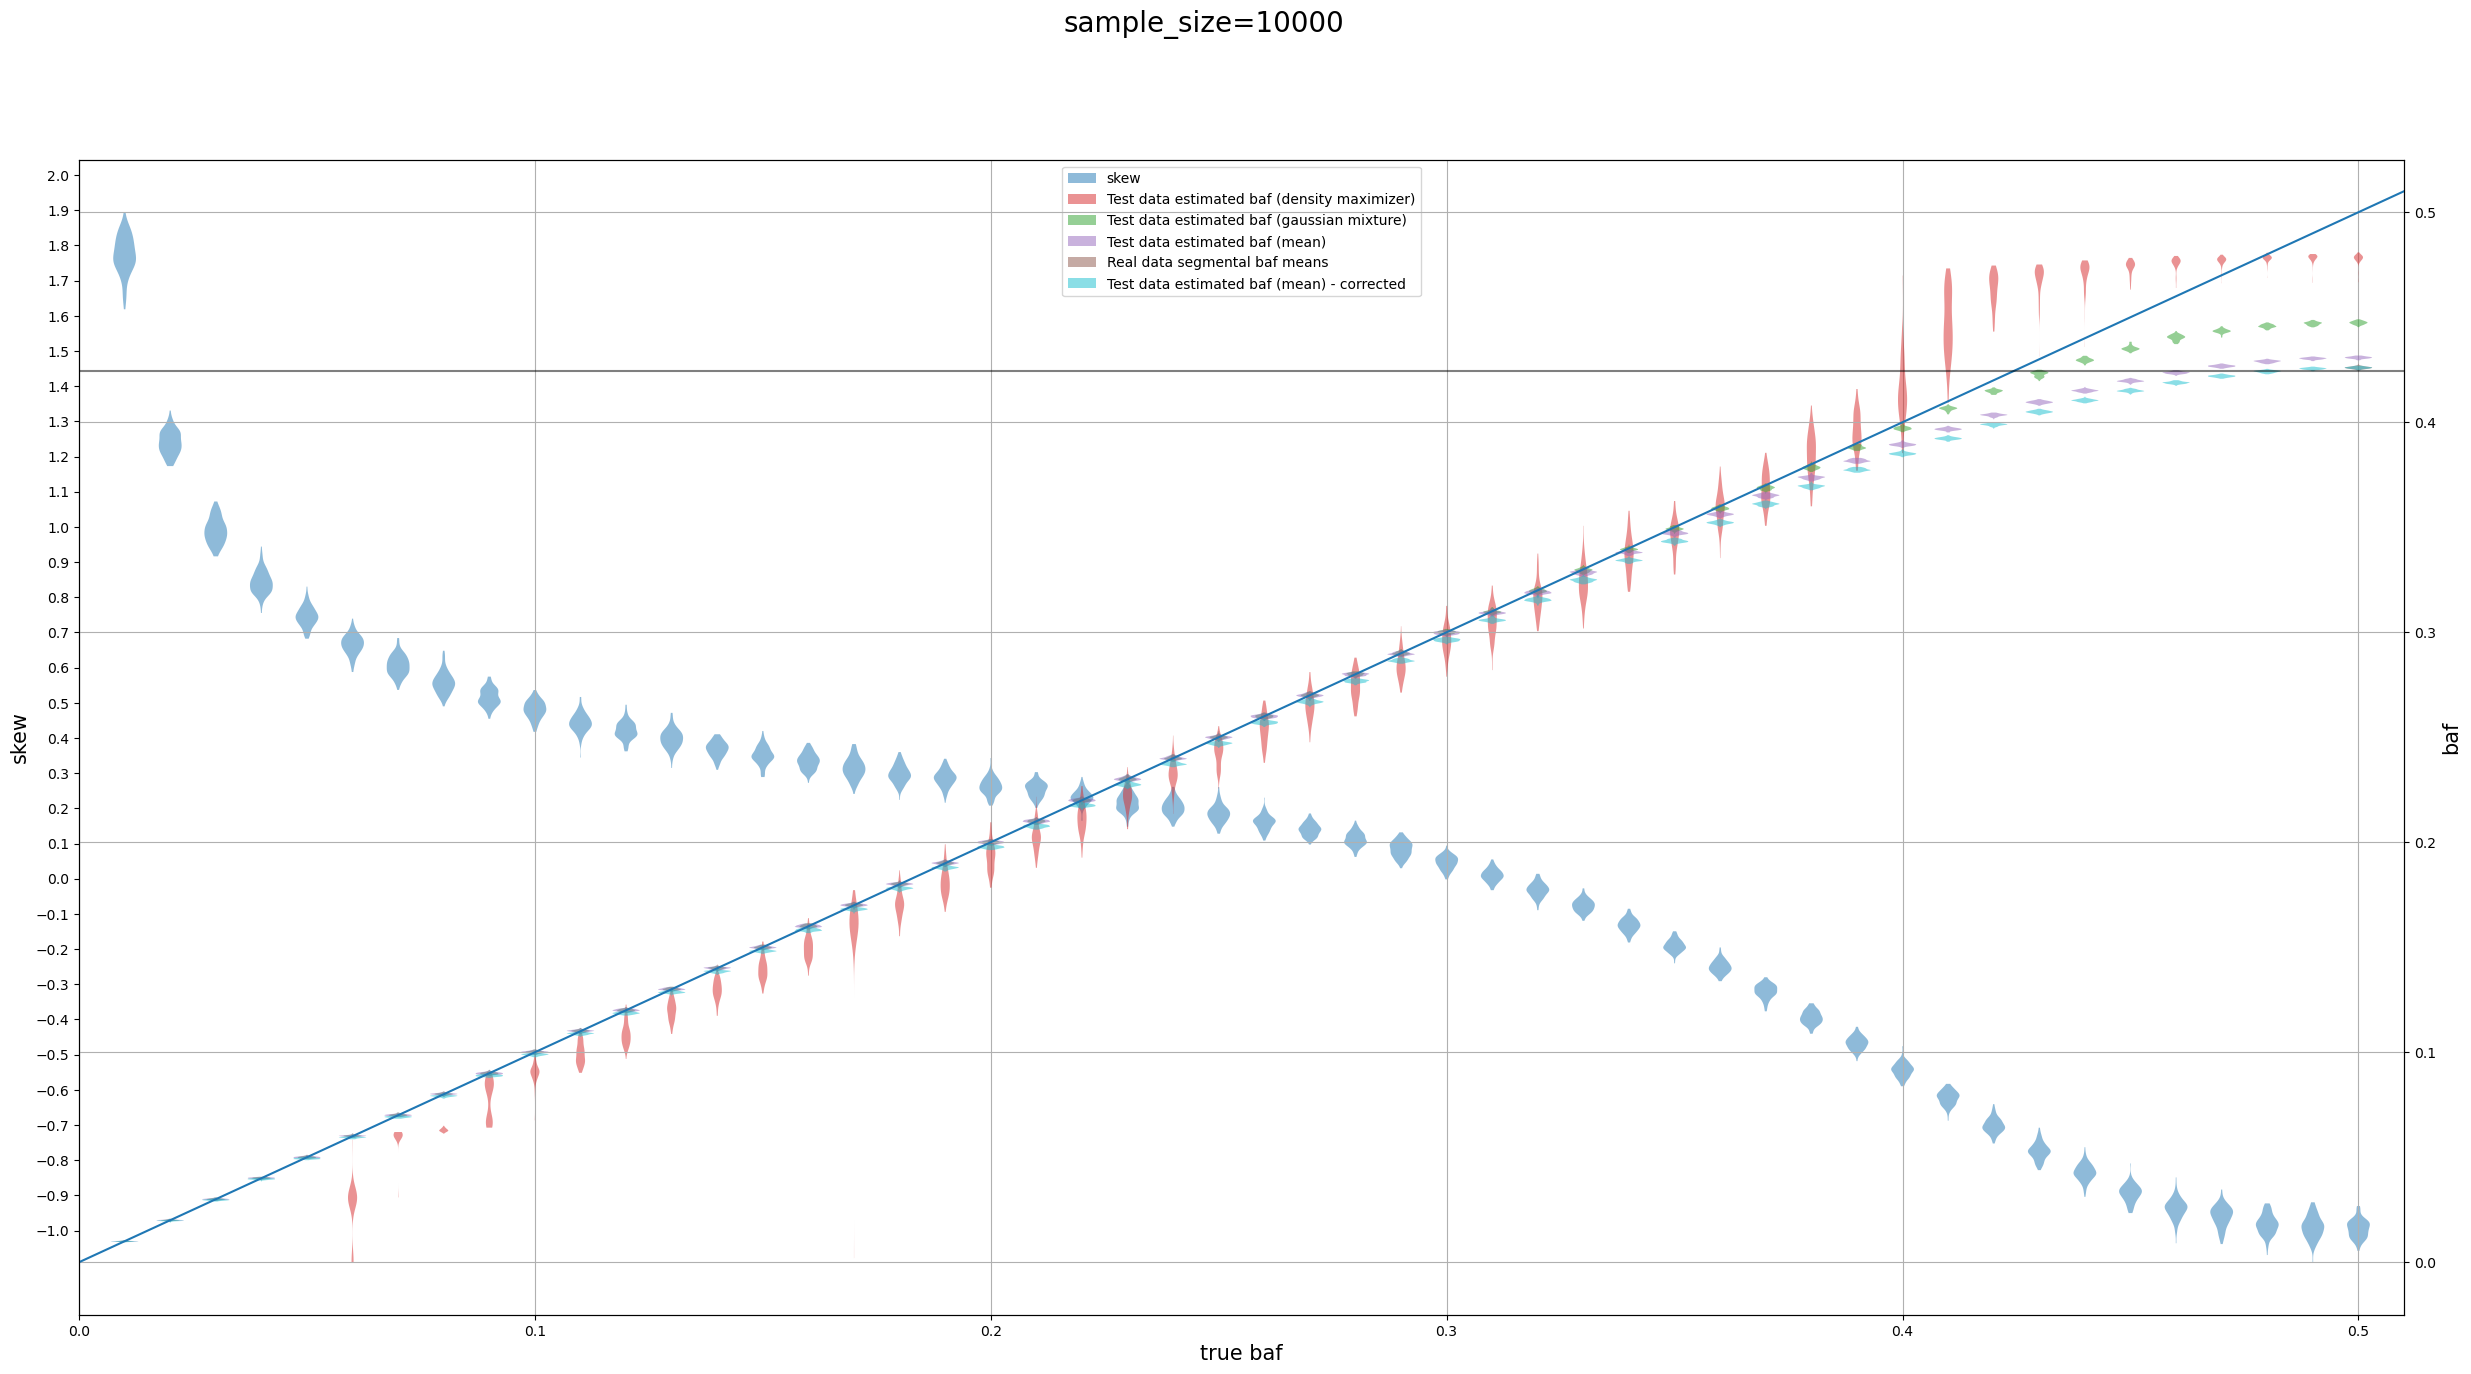

In [193]:
samplesize = 10000
subdata = dict()
for key, val in data[samplesize].items():
    subdata[key] = np.array([val[baf_val] for baf_val in true_bafs])

leghandles = list()

fig, ax = plt.subplots(figsize=(30, 15))
fig.suptitle(f'sample_size={samplesize}', fontsize=20)

ax.set_xlim(0, 0.51)
ax.grid(axis='x')
ax.set_yticks(np.arange(-1, 2.1, .1))
ax.set_xticks(np.arange(0, 0.6, 0.1))
ax.set_xlabel('true baf', fontsize=15)
ax.set_ylabel('skew', fontsize=15)

violins = ax.violinplot(subdata['skew'].T, positions=true_bafs, widths=0.005, showextrema=False)
violins['bodies'][0].set_label('skew')
leghandles.append(violins['bodies'][0])
for pc in violins['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_alpha(0.5)
    


ax2 = ax.twinx()
ax2.grid(axis='y')
ax2.axline((0, 0), (0.5, 0.5))
ax2.set_ylabel('baf', fontsize=15)

violins = ax2.violinplot(subdata['minimize'].T, positions=true_bafs, widths=0.002, showextrema=False)
violins['bodies'][0].set_label('Test data estimated baf (density maximizer)')
leghandles.append(violins['bodies'][0])
for pc in violins['bodies']:
    pc.set_facecolor('tab:red')
    pc.set_alpha(0.5)

violins = ax2.violinplot(subdata['mixture'].T, positions=true_bafs, widths=0.004, showextrema=False)
violins['bodies'][0].set_label('Test data estimated baf (gaussian mixture)')
leghandles.append(violins['bodies'][0])
for pc in violins['bodies']:
    pc.set_facecolor('tab:green')
    pc.set_alpha(0.5)
    
violins = ax2.violinplot(subdata['mean'].T, positions=true_bafs, widths=0.006, showextrema=False)
violins['bodies'][0].set_label('Test data estimated baf (mean)')
leghandles.append(violins['bodies'][0])
for pc in violins['bodies']:
    pc.set_facecolor('tab:purple')
    pc.set_alpha(0.5)
    
    
    
baf_means_realdata = np.array([np.random.choice(bafs_realdata, samplesize).mean() for x in range(10000)])
cutoff = np.quantile(baf_means_realdata, 0.01)
xs_ratio = baf_means_realdata.mean() / subdata['mean'][-1].mean()
corrected_means = subdata['mean'] * xs_ratio

violins = ax2.violinplot(baf_means_realdata[:, np.newaxis], positions=[0.50], widths=0.006, showextrema=False)
violins['bodies'][0].set_label('Real data segmental baf means')
leghandles.append(violins['bodies'][0])
for pc in violins['bodies']:
    pc.set_facecolor('tab:brown')
    pc.set_alpha(0.5)
ax2.axhline(cutoff, color='black', alpha=0.5)

violins = ax2.violinplot(corrected_means.T, positions=true_bafs, widths=0.006, showextrema=False)
violins['bodies'][0].set_label('Test data estimated baf (mean) - corrected')
leghandles.append(violins['bodies'][0])
for pc in violins['bodies']:
    pc.set_facecolor('tab:cyan')
    pc.set_alpha(0.5)


ax.legend(handles=leghandles, loc='upper center')

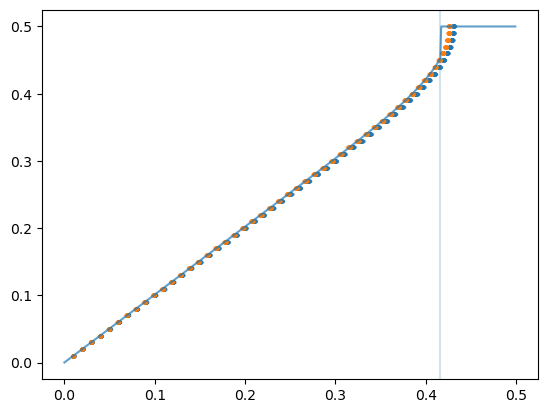

In [148]:
subdata = data[10000]
bafcorrector, interp, x_cutoff = libbaf.make_bafcorrector_from_realdata(subdata, bafs_realdata, mode='type1')

fig, ax = plt.subplots()
ax.plot(xs, ys, linestyle='', marker='o', markersize=1.7, alpha=0.2, color='tab:blue')
ax.plot(corrected_xs, ys, linestyle='', marker='o', markersize=1.7, alpha=0.2, color='tab:orange')
ax.axvline(x_cutoff, alpha=0.2)

newxs = np.arange(0, 0.5, 0.001)
newys = bafcorrector(newxs)
ax.plot(newxs, newys, linestyle='-', alpha=0.7)

In [156]:
libbaf.save_bafcorrect_func(interp, x_cutoff)

In [154]:
x_cutoff

0.41621271155970724

In [155]:
bafcorrector(0.42)

array(0.5)

(array([  7.,  24.,  20.,   0.,   0.,   0.,   0.,   0.,   0., 949.]),
 array([0.43820641, 0.44438577, 0.45056513, 0.45674449, 0.46292385,
        0.46910321, 0.47528256, 0.48146192, 0.48764128, 0.49382064,
        0.5       ]),
 <BarContainer object of 10 artists>)

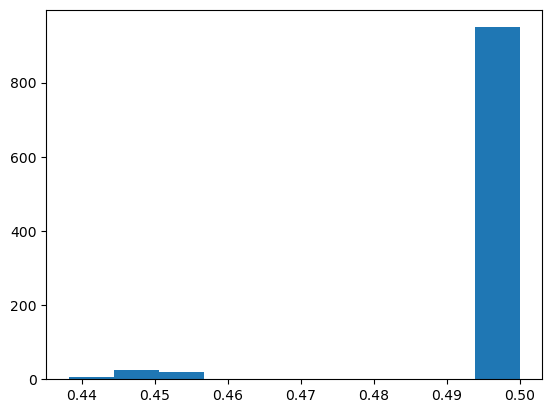

In [145]:
subdata = data[10000]
bafcorrector, interp, x_cutoff = libbaf.make_bafcorrector_from_realdata(subdata, bafs_realdata, mode='type1')

realdata_baf_means = np.array([np.random.choice(bafs_realdata, 100).mean() for x in range(1000)])
corrected_baf_means = bafcorrector(realdata_baf_means)
plt.hist(corrected_baf_means)

In [116]:
test_data = dict()
for size in (100, 1000, 10000):
    print(f'size {size}')
    test_data[size] = libbaf.make_simulation_data(mean_depth=34, size=size, reps=100, true_bafs=true_bafs)

size 100
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
size 1000
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
size 10000
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5


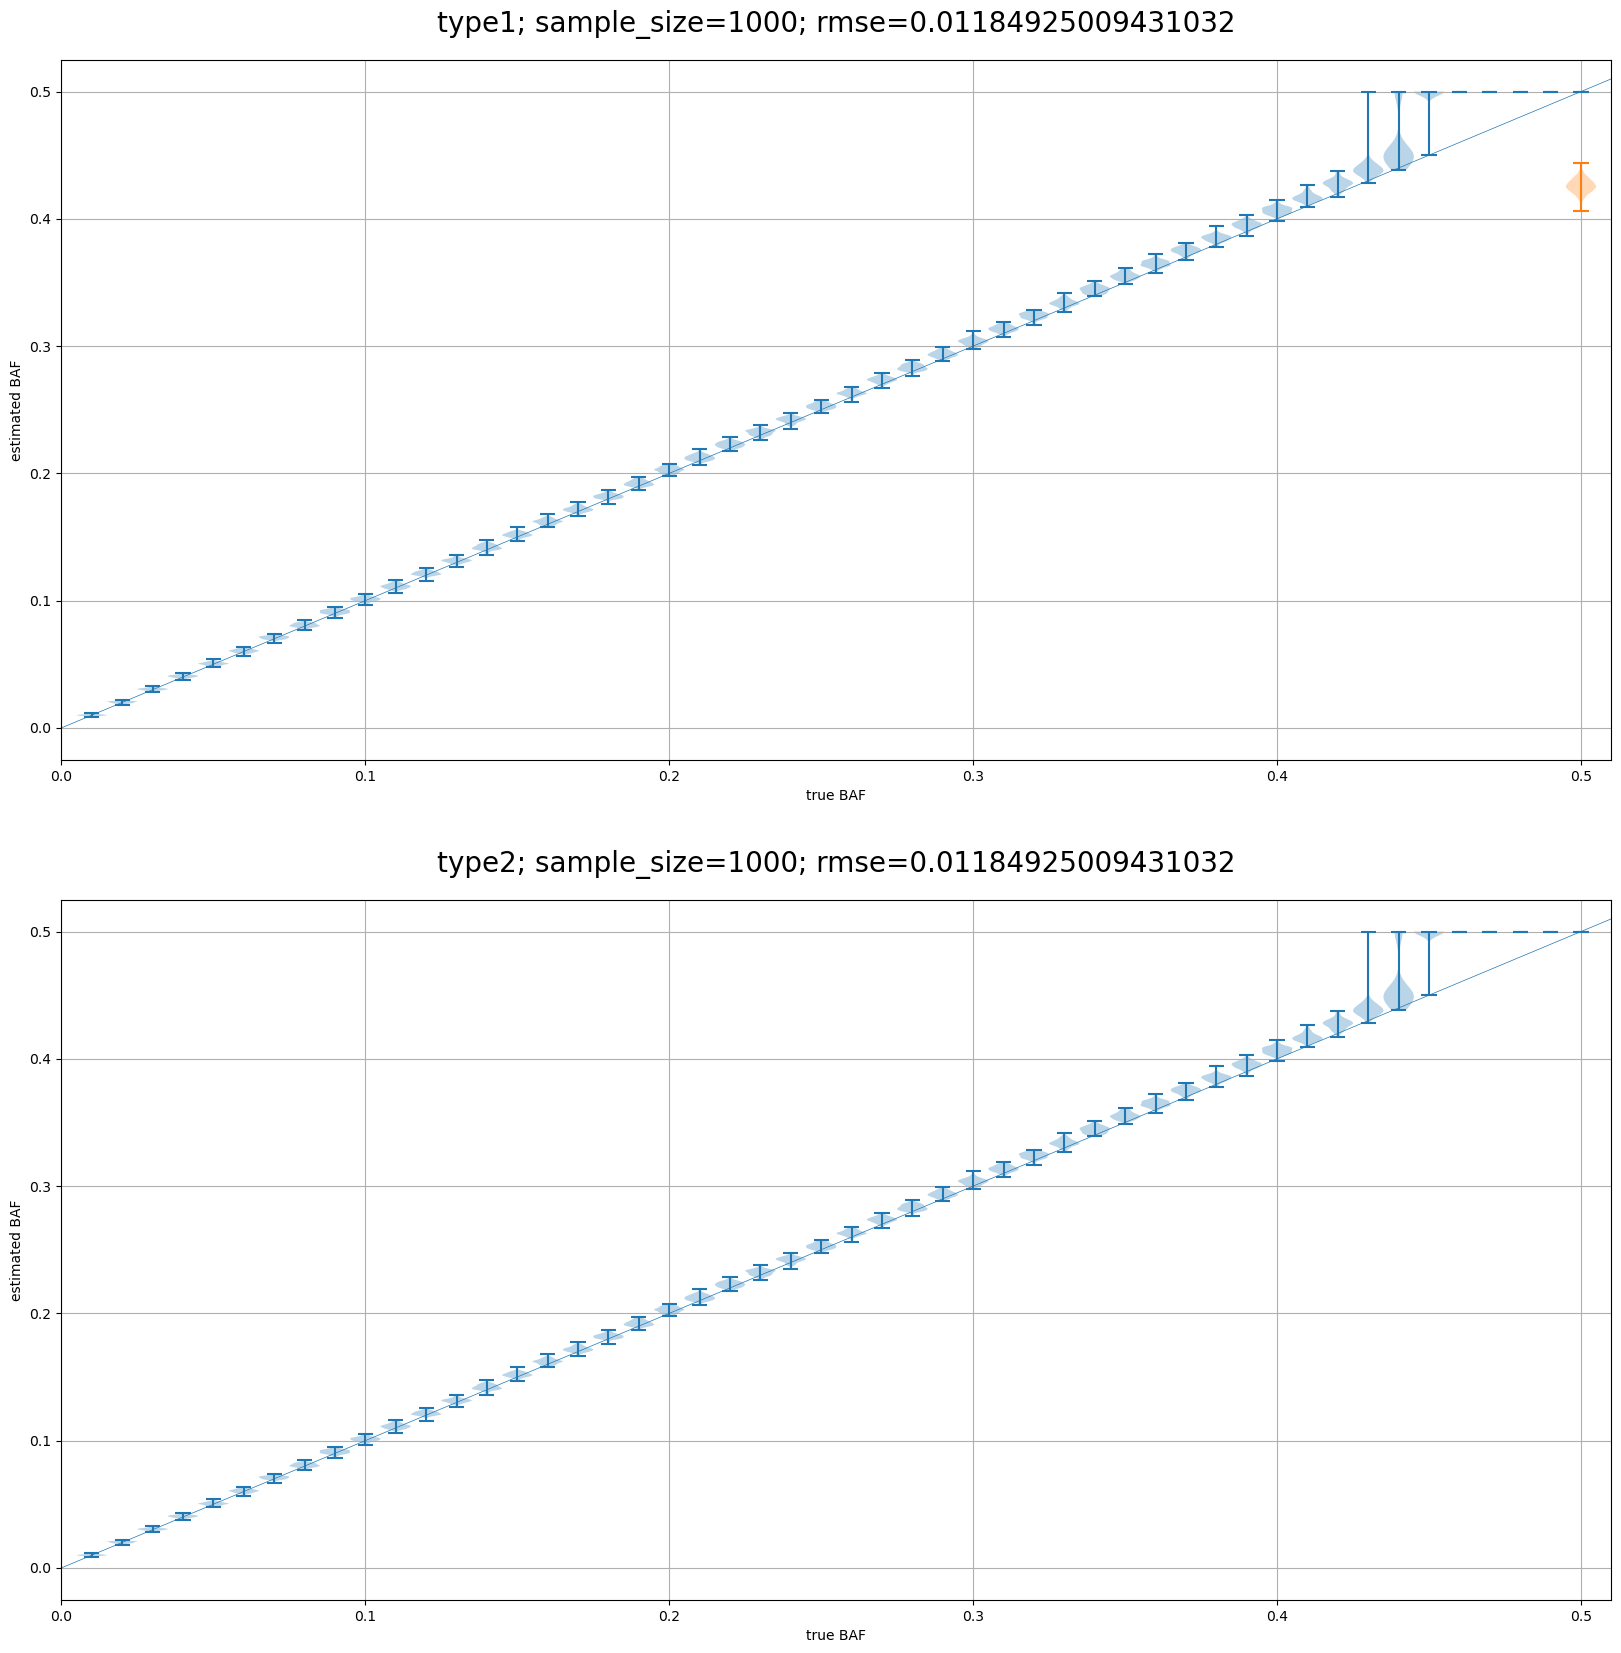

In [124]:
samplesize = 1000

def get_rmse(estimated_values):
    true_vals = np.repeat(
        list(estimated_values.keys()),
        [len(x) for x in estimated_values.values()],
    )
    est_vals = np.fromiter(itertools.chain.from_iterable(iter(estimated_values.values())), dtype=float)
    rms = np.sqrt(((true_vals - est_vals)**2).mean())
    return rms

xs_ratio = libbaf.get_xs_ratio(data[10000], bafs_realdata)
x_cutoff = libbaf.get_x_cutoff(bafs_realdata)

baf_corrector_type1, _, _, _ = libbaf.make_bafcorrector_type1(data[10000], xs_ratio)
baf_corrector_type1 = libbaf.winsorize_pointfive(baf_corrector_type1, x_cutoff)

baf_corrector_type2, _, _, _ = libbaf.make_bafcorrector_type2(data[10000], xs_ratio)
baf_corrector_type2 = libbaf.winsorize_pointfive(baf_corrector_type1, x_cutoff)


est_values_type1 = dict()
est_values_type2 = dict()
subdata = test_data[samplesize]
for true_baf_val in true_bafs:
    means = subdata['mean'][true_baf_val]
    est_values_type1[true_baf_val] = baf_corrector_type1(means)
    est_values_type2[true_baf_val] = baf_corrector_type2(means)


realdata_baf_means = np.array([np.random.choice(bafs_realdata, 100).mean() for x in range(1000)])

fig, axs = plt.subplots(2, 1, figsize=(20, 20))
for ax in axs:
    ax.set_xlim(0, 0.51)
    ax.grid()
    ax.set_xlabel('true BAF')
    ax.set_ylabel('estimated BAF')
    ax.axline((0, 0), (0.5, 0.5), linewidth=0.5)

axs[0].set_title(f'type1; sample_size={samplesize}; rmse={get_rmse(est_values_type1)}', fontsize=20, pad=20)
_ = axs[0].violinplot(
    [est_values_type1[x] for x in true_bafs],
    true_bafs,
    widths=0.01,
)
_ = axs[0].violinplot(
    realdata_baf_means[:, np.newaxis],
    [0.5],
    widths=0.01,
)


axs[1].set_title(f'type2; sample_size={samplesize}; rmse={get_rmse(est_values_type2)}', fontsize=20, pad=20)
_ = axs[1].violinplot(
    [est_values_type2[x] for x in true_bafs],
    true_bafs,
    widths=0.01,
)

In [174]:
baf_corrector_type1, _, _ = libbaf.make_bafcorrector_type1(data[10000])
libbaf.save_bafcorrect_func(baf_corrector_type1)

In [175]:
baf_corrector = libbaf.load_bafcorrect_func()

In [176]:
baf_corrector

<function handygenome.cnv.baf.winsorize_pointfive.<locals>.newfunc(x)>